In [1]:
import polars as pl,glob,os,json
from IPython.display import display

In [ ]:
class BiddingLazyframe:
    def __init__(self, spec=-1, dataset_path=r'D:\allcode\hacks\Devcraft25\dataset'):
        self.type = 'bid'
        self.bid_columns = [
            'bidId','time_stamp','cookieId','user_agent','ip_addr','region','city','exchange',
            'domain','url','anonymousURL','adslotid','adslotwidth','adslotheight','adslotvisibility',
            'adslotformat','adslotfloorprice','creativeid','bidding_price','advertiser_id','user_profile_id'
        ]

        self.other_columns = [
            'bidId','time_stamp','log_type','cookieId','user_agent','ip_addr','region','city','exchange',
            'domain','url','anonymousURL','adslotid','adslotwidth','adslotheight','adslotvisibility',
            'adslotformat','adslotfloorprice','creativeid','bidding_price','paying_price','landing_url',
            'advertiser_id','final_user_profile_id'
        ]
        
        bid_dict_map = dict(map(lambda k: (f"column_{k[0]+1}",k[1]) , enumerate(self.bid_columns)))
        other_dict_map = dict(map(lambda k: (f"column_{k[0]+1}",k[1]) , enumerate(self.other_columns)))
        
        
        #define helper functions for preprocessing
        load_lf = lambda type , spec, dataset_path: pl.concat([pl.scan_csv(file, separator='\t', has_header=False) 
                                                               for file in glob.glob(f'{dataset_path}\\{type}.{'*' if spec == -1 else str(spec).zfill(2)}.txt')])
        get_bidId_set = lambda x: set(load_lf(x,spec,dataset_path).select('column_1').collect()['column_1'].to_list())
        add_col_from_set = lambda lf , type_set , col_name : lf.with_columns(pl.col('bidId').is_in(type_set).alias(col_name))
        get_rem_cols_lazy = lambda lf, col_names, imp_lf: lf.join(imp_lf.select(['bidId'] + col_names), on='bidId', how='left')
        
        
        
        self.df = load_lf('bid',spec,dataset_path).rename(bid_dict_map)
        self.impression , self.click , self.conversion = [get_bidId_set(attr) for attr in ['imp','clk','conv']]
        self.df = add_col_from_set(self.df,self.impression,'impression_bool')
        self.df = add_col_from_set(self.df,self.click,'click_bool')
        self.df = add_col_from_set(self.df,self.conversion,'conversion_bool')
        imp_lf = load_lf('imp', spec, dataset_path).rename(other_dict_map)
        self.df = get_rem_cols_lazy(self.df, ['paying_price', 'landing_url', 'final_user_profile_id'], imp_lf)
        self.df = self.df.with_columns([
                    (pl.col("time_stamp") // 1000000000).cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias("date"),
                    (
                        ((pl.col("time_stamp") // 1000000 % 100).cast(pl.Int32) * 4) +
                        ((pl.col("time_stamp") // 10000 % 100).cast(pl.Int32) // 15)
                    ).alias("time_block"),
                    (pl.col("time_stamp") // 1000000000).cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").dt.weekday().alias("day_of_week")
                ]).drop("time_stamp")
        ua = pl.col("user_agent").str.to_lowercase()
        self.df = self.df.with_columns([
                    pl.when(ua.str.contains("ios") | ua.str.contains("iphone") | ua.str.contains("ipad") | ua.str.contains("ipod")).then(pl.lit("ios"))  # Use pl.lit for string literals
                    .when(ua.str.contains("mac") | ua.str.contains("darwin") | ua.str.contains("macintosh") ).then(pl.lit("mac"))  # Use pl.lit
                    .when(ua.str.contains("windows")).then(pl.lit("windows"))  # Use pl.lit
                    .when(ua.str.contains("linux")).then(pl.lit("linux"))  # Use pl.lit
                    .when(ua.str.contains("android")).then(pl.lit("android"))  # Use pl.lit
                    .otherwise(pl.lit("other")).alias("device"),  # Use pl.lit
                    pl.when(ua.str.contains("safari")).then(pl.lit("safari"))
                    .when(ua.str.contains("chrome")).then(pl.lit("chrome"))  # Use pl.lit
                    .when(ua.str.contains("firefox") | ua.str.contains("mozilla")).then(pl.lit("firefox"))  # Use pl.lit
                    .when(ua.str.contains("edge")).then(pl.lit("edge"))  # Use pl.lit
                    .when(ua.str.contains("msie") | ua.str.contains("trident")).then(pl.lit("msie"))
                    .otherwise(pl.lit("other")).alias("browser")
                ])
        width = pl.col("adslotwidth").cast(pl.Float32)  # Cast to float for division
        height = pl.col("adslotheight").cast(pl.Float32)
        self.df = self.df.with_columns(
                        pl.when(width / height > 3).then(pl.lit("banner"))
                        .when((width / height > 1.2) & (width / height < 2)).then(pl.lit("rectangle"))  # Adjusted ratio
                        .when((width / height >= 0.8) & (width / height <= 1.2)).then(pl.lit("square"))  # Adjusted ratio
                        .when(height / width > 1.2).then(pl.lit("vertical"))  # Use height/width ratio
                        .otherwise(pl.lit("other")).alias("ad_type")
                    )
        self.df = self.df.with_columns([
                pl.col("region").cast(pl.Utf8),
                pl.col("city").cast(pl.Utf8),
                pl.col("exchange").cast(pl.Utf8),
                pl.col("adslotwidth").cast(pl.Int16),
                pl.col("adslotheight").cast(pl.Int16),
                pl.when(pl.col("adslotvisibility") == 255).then(-1).otherwise(pl.col("adslotvisibility")).cast(pl.Int8).alias("adslotvisibility"),  # Convert 255 to -1 and cast to int8
                pl.col("adslotformat").cast(pl.Int8),
                pl.col("adslotfloorprice").cast(pl.Int32),
                pl.col("bidding_price").cast(pl.Int32),
                pl.col("advertiser_id").cast(pl.Int32),
                pl.col("paying_price").cast(pl.Int32),
                pl.col("time_block").cast(pl.Int16)
            ])

        self.df = self.df.drop(['cookieId','user_agent','ip_addr','domain','url','anonymousURL','adslotid','user_profile_id','landing_url'])
        
    def write_to_directory(self, output_dir, by_col="advertiser_id"):
        if not os.path.exists(output_dir): os.makedirs(output_dir)
        unique_groups = self.df.select(by_col).unique().collect()[by_col].to_list()
        print(unique_groups)
        for group in unique_groups:
            print(f"Processing group: {group}")
            lf_subset = self.df.filter(pl.col(by_col) == group)
            lf_subset.sink_parquet(f"{output_dir}/{group}.parquet",compression='zstd',compression_level=20)
            print(f"Finished processing group: {group}")
            
    
            
lf = BiddingLazyframe()

In [3]:
lf.write_to_directory(r"D:\allcode\hacks\Devcraft25\tarun_bhai_ka_data")

[3427, 3386, 3476, 1458, 3358]
Processing group: 3427
Finished processing group: 3427
Processing group: 3386
Finished processing group: 3386
Processing group: 3476
Finished processing group: 3476
Processing group: 1458
Finished processing group: 1458
Processing group: 3358
Finished processing group: 3358


In [12]:
lf.df.head(100).collect(streaming=True)

bidId,region,city,exchange,adslotwidth,adslotheight,adslotvisibility,adslotformat,adslotfloorprice,creativeid,bidding_price,advertiser_id,impression_bool,click_bool,conversion_bool,paying_price,final_user_profile_id,date,time_block,day_of_week,device,browser,ad_type
str,str,str,str,i16,i16,i8,i8,i32,str,i32,i32,bool,bool,bool,i32,str,date,i16,i8,str,str,str
"""b382c1c156dcbbd5b9317cb50f6a74…","""80""","""87""","""1""",300,250,1,1,0,"""00fccc64a1ee2809348509b7ac2a97…",227,3427,false,false,false,null,null,2013-06-06,0,4,"""windows""","""firefox""","""square"""
"""7b6195de0d14203f92001da653bf1d…","""216""","""217""","""2""",468,60,1,0,5,"""2f88fc9cf0141b5bbaf251cab07f4c…",300,3386,true,false,false,18,"""null""",2013-06-06,0,4,"""windows""","""firefox""","""banner"""
"""2ea9fe21cf7350fcb5696d8cff0bbe…","""65""","""69""","""1""",950,90,1,1,0,"""23d6dade7ed21cea308205b3759400…",227,3427,false,false,false,null,null,2013-06-06,0,4,"""windows""","""firefox""","""banner"""
"""8a15b98c8f9e60d4f92aaab01acf52…","""106""","""117""","""1""",950,90,0,1,0,"""23d6dade7ed21cea308205b3759400…",227,3427,true,false,false,207,"""10063,10684,10083,13403,10059,…",2013-06-06,0,4,"""windows""","""safari""","""banner"""
"""faf17eac9cabf1be598f4e75f40d50…","""94""","""95""","""1""",950,90,0,1,0,"""d5cecca9a6cbd7a0a48110f1306b26…",227,3358,true,false,false,108,"""10059,13866,10063,10111""",2013-06-06,0,4,"""windows""","""safari""","""banner"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""5461589ac8f2672f413a5c5993c768…","""216""","""217""","""1""",300,250,1,1,0,"""d881a6c788e76c2c27ed1ef04f1195…",227,3358,false,false,false,null,null,2013-06-06,0,4,"""windows""","""firefox""","""square"""
"""42793ee70a154896e5ec829f2b15ee…","""344""","""350""","""1""",336,280,2,1,0,"""13606a7c541dcd9ca1948875a760bb…",227,3358,true,false,false,14,"""10006,10110""",2013-06-06,0,4,"""windows""","""firefox""","""square"""
"""20fb85784972aebed3dda8d20ca87a…","""216""","""217""","""1""",300,250,0,5,0,"""d881a6c788e76c2c27ed1ef04f1195…",227,3358,true,false,false,89,"""13866,10111""",2013-06-06,0,4,"""android""","""other""","""square"""


In [21]:
import polars as pl,os,numpy as np,glob,json
class TestingFrame:
    def __init__(self,spec=-1, dataset_path=r'D:\allcode\hacks\Devcraft25\dataset'):
        self.bid_columns = [
            'bidId','time_stamp','cookieId','user_agent','ip_addr','region','city','exchange',
            'domain','url','anonymousURL','adslotid','adslotwidth','adslotheight','adslotvisibility',
            'adslotformat','adslotfloorprice','creativeid','bidding_price','advertiser_id','user_profile_id'
        ]

        self.other_columns = [
            'bidId','time_stamp','log_type','cookieId','user_agent','ip_addr','region','city','exchange',
            'domain','url','anonymousURL','adslotid','adslotwidth','adslotheight','adslotvisibility',
            'adslotformat','adslotfloorprice','creativeid','bidding_price','paying_price','landing_url',
            'advertiser_id','final_user_profile_id'
        ]
        
        bid_dict_map = dict(map(lambda k: (f"column_{k[0]+1}",k[1]) , enumerate(self.bid_columns)))
        other_dict_map = dict(map(lambda k: (f"column_{k[0]+1}",k[1]) , enumerate(self.other_columns)))
        
        load_lf = lambda type , spec, dataset_path: pl.concat([pl.scan_csv(file, separator='\t', has_header=False) 
                                                               for file in glob.glob(f'{dataset_path}\\{type}.{'*' if spec == -1 else str(spec).zfill(2)}.txt')])
        
        self.lf = load_lf('imp',spec,dataset_path).rename(other_dict_map)
        
        
        self.lf = self.lf.with_columns([
                    (pl.col("time_stamp") // 1000000000).cast(pl.Utf8).str.strptime(pl.Date,'%Y%m%d').alias('date'),
                    (
                        ((pl.col("time_stamp") // 1000000 % 100).cast(pl.Int32) * 4) +
                        ((pl.col("time_stamp") // 10000 % 100).cast(pl.Int32) // 15)
                    ).alias("time_block"),
                    (pl.col("time_stamp") // 1000000000).cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").dt.weekday().alias("day_of_week")
        ])
        
        
        self.dispdict = (
                    self.lf.with_columns(pl.col("final_user_profile_id").str.split(",").alias("user_profiles"))
                    .explode("user_profiles")
                    .group_by(["creativeid", "user_profiles"])  # Group by both creativeid and user_profiles
                    .agg(pl.len().alias("count"))
                    .collect(streaming=True)
                    .to_pandas()
                    .groupby("creativeid")  # Group again by creativeid to create nested dict
                    .apply(lambda x: x.set_index("user_profiles")["count"].to_dict())  # Create nested dict
                    .to_dict()
                )
        
        def create_top_adslot_creative_map(lf, top_n=1000):
            top_adslot_ids = (
                lf.group_by("adslotid")
                .agg(pl.len().alias("count"))
                .sort("count", descending=True)
                .limit(top_n)
                .select("adslotid")
                .collect(streaming=True)
                .to_series()
                .to_list()
            )

            return (
                lf.filter(pl.col("adslotid").is_in(top_adslot_ids))
                .group_by(["adslotid", "creativeid"])
                .agg(pl.len().alias("count"))
                .collect(streaming=True)
                .to_pandas()
                .groupby("creativeid")
                .apply(lambda x: x.set_index("adslotid")["count"].to_dict())
                .to_dict()
            )
        
        self.domain_to_creative = create_top_adslot_creative_map(self.lf)
         
    
dlf = TestingFrame()
print(dlf.domain_to_creative)
pl.Config.set_tbl_rows(100)
dlf.lf.tail(4).collect()
# with open('dict.json','w') as f: f.write(json.dumps(json.loads(json.dumps(dlf.dispdict)),indent=4))

C:\Users\Zephy\AppData\Local\Temp\ipykernel_23000\3036914851.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("user_profiles")["count"].to_dict())  # Create nested dict
C:\Users\Zephy\AppData\Local\Temp\ipykernel_23000\3036914851.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("adslotid")["count"].to_dict())


{'0055e8503dc053435b3599fe44af118b': {'4163066567': 247, '1957123273': 174, '2676082090': 267, '1140040786': 165, '1': 4, '3814439907': 239, '884422784': 1000, '1391491877': 396, '3631707110': 186, '196738611': 317, '932233619': 192}, '00fccc64a1ee2809348509b7ac2a97a5': {'mm_33525363_3418064_13064226': 228, 'mm_31002104_3232316_10605181': 509, 'mm_32045550_3152709_10441712': 238, '2884791033': 161, 'tips_F_Rectangle1': 8631, 'mm_26487320_3338624_10864340': 406, 'mm_10562317_2833977_10791752': 97, 'mm_11029759_2321526_9427924': 1728, 'mm_41272534_3509703_13026459': 129, '1782380027': 407, '3755978631': 324, '1624756681': 966, '2808233738': 330, '2044900168': 466, 'mm_35068870_3467174_11285499': 117, '3261131688': 268, '1207568570': 114, 'mm_11106913_1054947_3834593': 555, 'mm_37229916_3484562_11377235': 154, 'mm_10009936_105923_10950458': 2119, 'mm_10839307_2308336_9004871': 2406, 'mm_30657328_2767449_10470467': 160, 'mm_33556857_3419556_11056140': 345, 'mm_26782446_2390794_9678809': 31

bidId,time_stamp,log_type,cookieId,user_agent,ip_addr,region,city,exchange,domain,url,anonymousURL,adslotid,adslotwidth,adslotheight,adslotvisibility,adslotformat,adslotfloorprice,creativeid,bidding_price,paying_price,landing_url,advertiser_id,final_user_profile_id,date,time_block,day_of_week
str,i64,i64,str,str,str,i64,i64,i64,str,str,str,str,i64,i64,i64,i64,i64,str,i64,i64,str,i64,str,date,i32,i8
"""7dd316c73424cfc53c7cc927f8db6a…",20130612233725743,1,"""VhTAZrMN3eChlfb""","""Mozilla/5.0 (iPad; CPU OS 5_1_…","""115.175.13.*""",183,184,3,"""ersbQv1RdoTy1m58uG""","""2d7a2e9f123fab7689608bfa0cdd21…","""null""","""Sports_F_Width1""",1000,90,0,0,20,"""c46090c887c257b61ab1fa11baee91…",241,22,"""0f951a030abdaedd733ee8d114ce29…",3427,"""13403,10024,10083,10077,10063,…",2013-06-12,136,3
"""81fc22e0c022225f635c1889f197b7…",20130612234017010,1,"""Vh5z1u1TOHT6aGb""","""null""","""117.136.12.*""",216,217,3,"""3FF-e59aG5syJqKbuKz""","""edde3fe7d9703f57e0b8e411f4182f…","""null""","""ALLINONE_F_Width1""",1000,90,0,0,70,"""832b91d59d0cb5731431653204a76c…",300,70,"""bebefa5efe83beee17a3d245e7c508…",1458,"""null""",2013-06-12,136,3
"""967094bc50602533e4c48924e1d916…",20130612234204173,1,"""Vh5z1ulxONchJBb""","""Mozilla/5.0 (iPad; CPU OS 6_1_…","""182.242.85.*""",308,309,1,"""trqRTudJMNSvFsC4JKTI""","""d913d9e9b8a56c6f0adfc7604a1097…","""null""","""mm_10024662_3436146_11141138""",336,280,2,1,0,"""77819d3e0b3467fe5c7b16d68ad923…",300,11,"""bebefa5efe83beee17a3d245e7c508…",1458,"""null""",2013-06-12,137,3
"""d6d7fede767a9da89b2b58f015e149…",20130612235128618,1,"""Vh5zPJqP36TCFsl""","""Mozilla/5.0 (Linux; U; Android…","""27.152.193.*""",124,129,1,"""trqRTv18Oe2W1m58uG""","""265c6e9528b62f5a42fd2aa83bb4f2…","""null""","""mm_13049339_2520298_10128579""",950,90,1,1,0,"""fa8f0532dd5144b5fa748459e8d90b…",227,225,"""0f951a030abdaedd733ee8d114ce29…",3427,"""10063""",2013-06-12,140,3


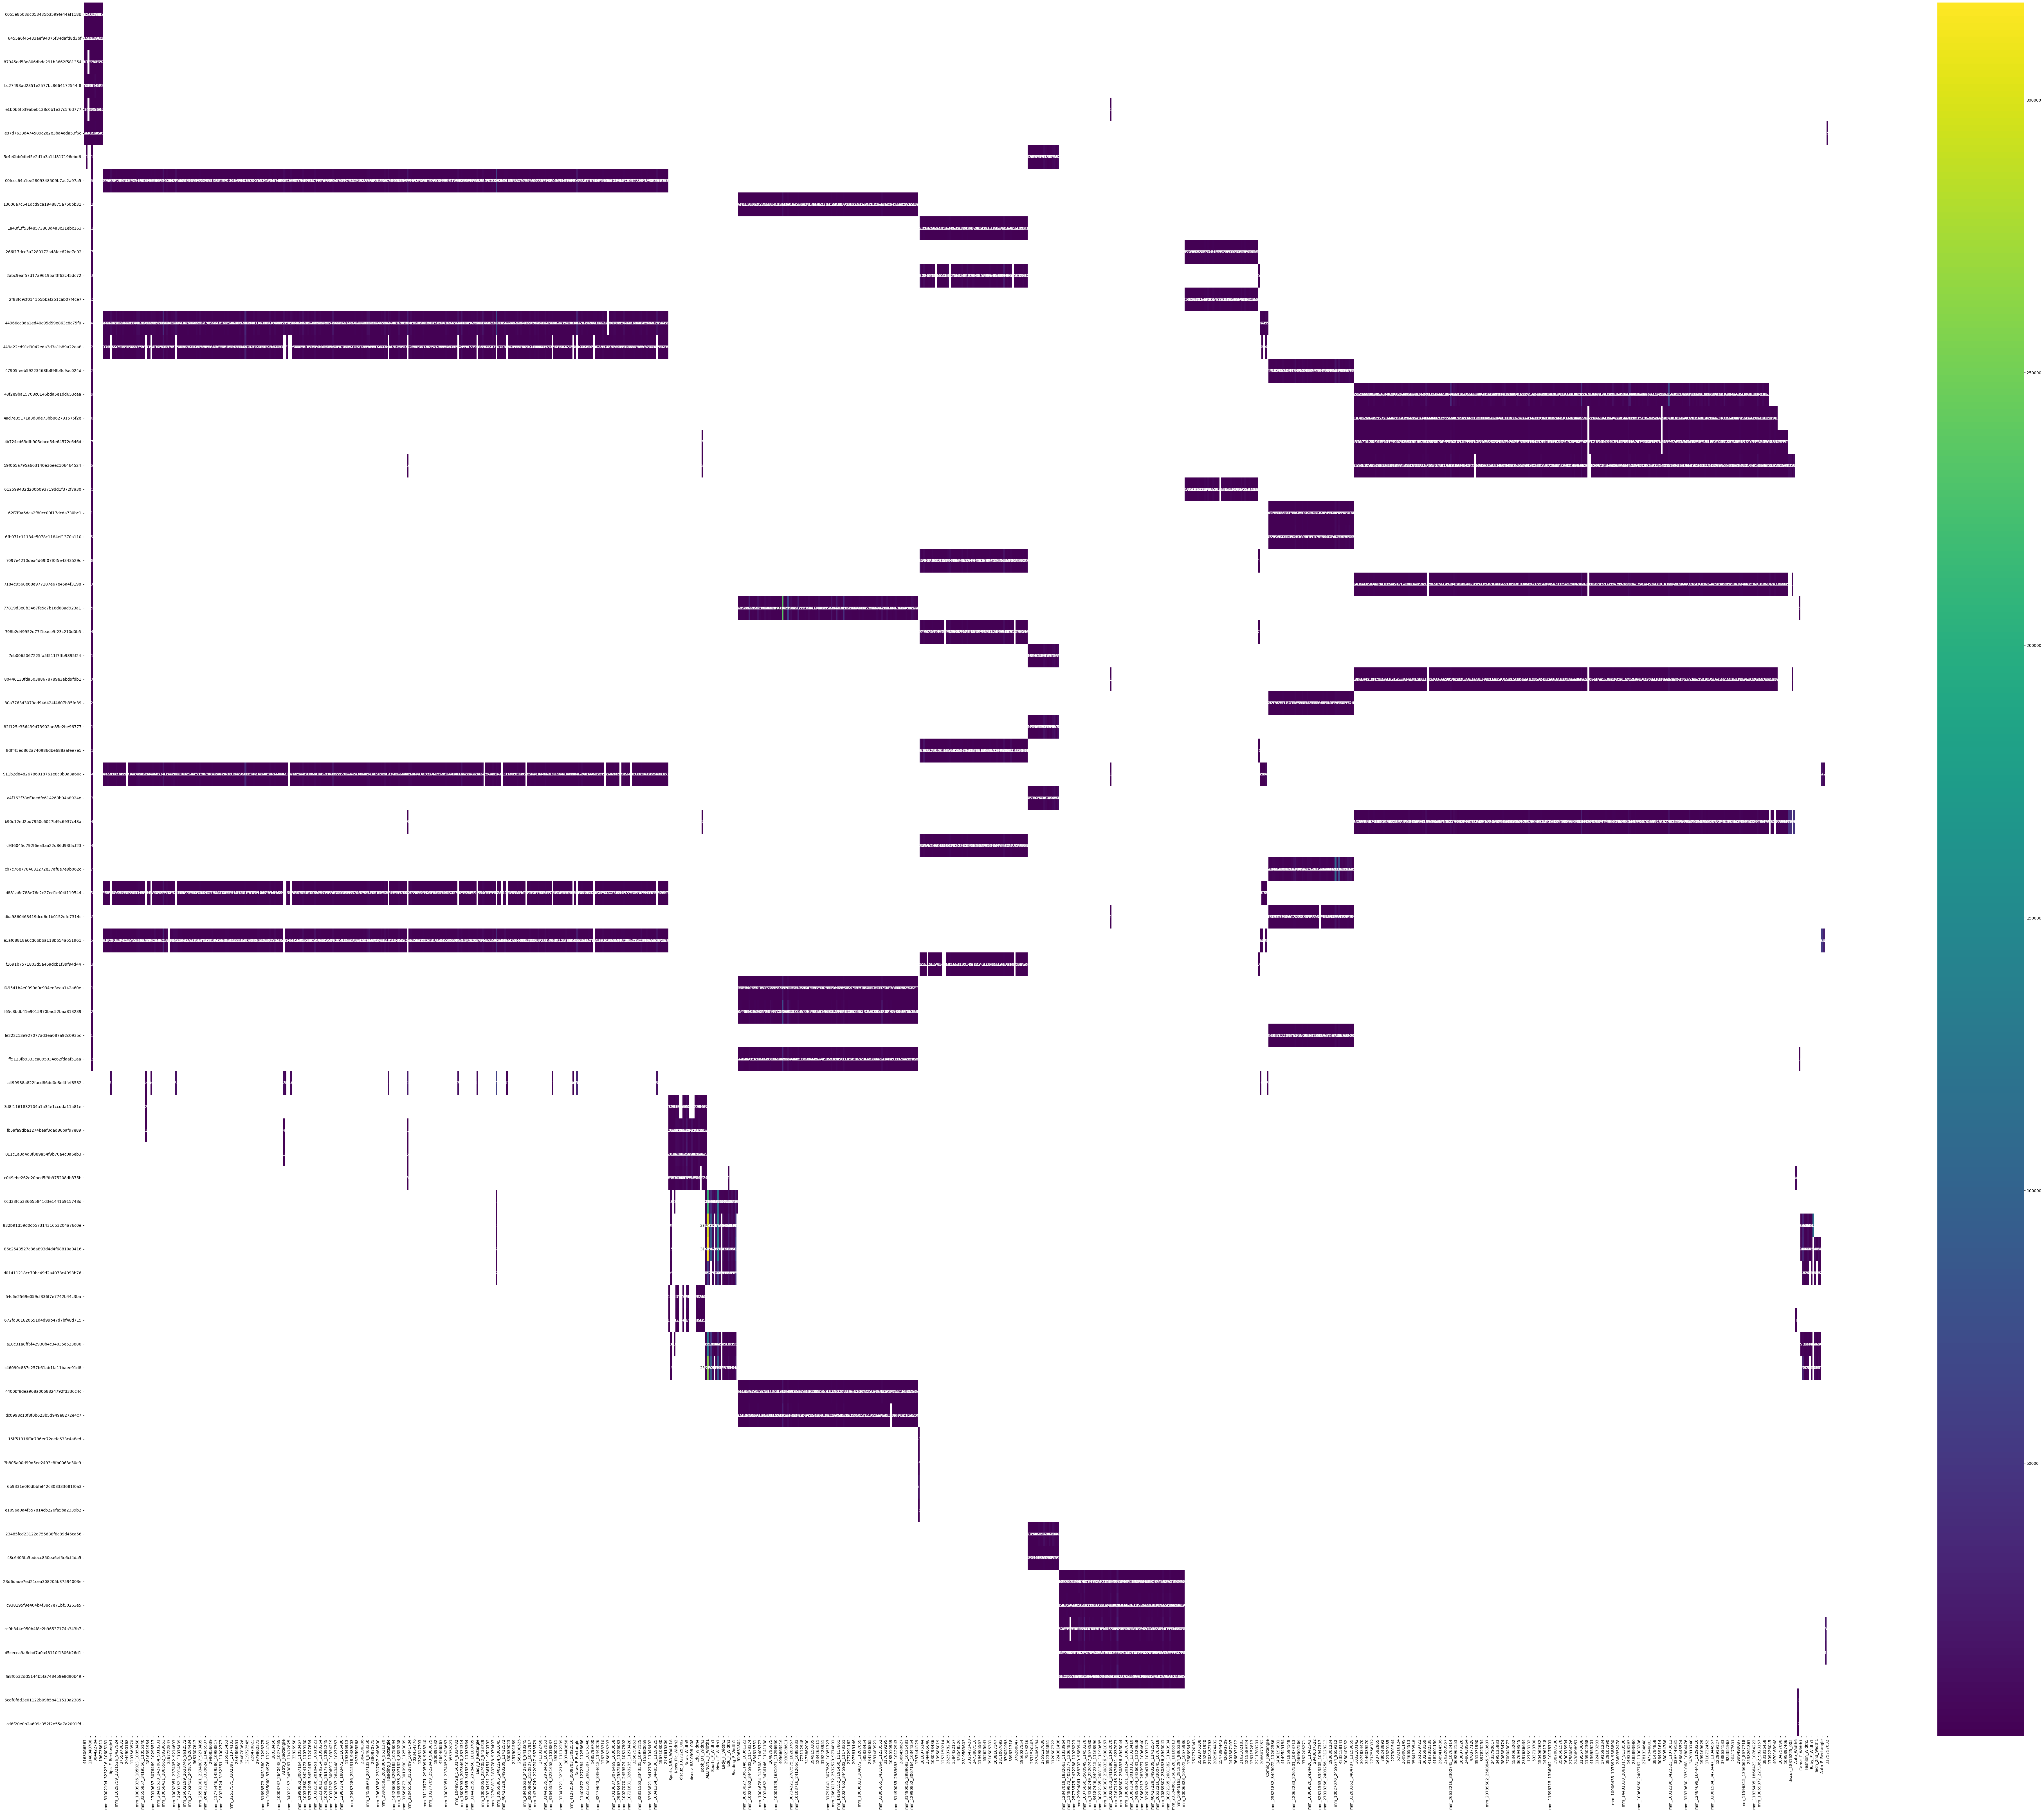

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
def plot_heatmap_from_dict(data, figsize=(10, 8)):
    df = pd.DataFrame.from_dict(data, orient='index')
    plt.figure(figsize=figsize)
    sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f",
                vmin=df.min().min(), vmax=df.max().max())
    plt.show()
plot_heatmap_from_dict(dlf.domain_to_creative,figsize=(100,80))

In [ ]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

# -----------------------------------------------------------------
# 1. User-Agent Parsing Utilities
# -----------------------------------------------------------------
def xtract_device_family(user_agent_str):
    if isinstance(user_agent_str, str):
        ua = user_agent_str.lower()
        if ("mobile" in ua or "android" in ua or "iphone" in ua or "ipad" in ua):
            return "Tablet" if "ipad" in ua else "Mobile"
        elif ("windows" in ua or "macintosh" in ua or "linux" in ua):
            return "Desktop"
        else:
            return "Other"
    return "Unknown"

def xtract_os_family(user_agent_str):
    if isinstance(user_agent_str, str):
        ua = user_agent_str.lower()
        if "windows" in ua:
            return "Windows"
        elif "macintosh" in ua or "macos" in ua:
            return "MacOS"
        elif "android" in ua:
            return "Android"
        elif ("ios" in ua or "iphone" in ua or "ipad" in ua):
            return "iOS"
        elif "linux" in ua:
            return "Linux"
        else:
            return "Other"
    return "Unknown"

def xtract_browser_family(user_agent_str):
    if isinstance(user_agent_str, str):
        ua = user_agent_str.lower()
        if "chrome" in ua:
            return "Chrome"
        elif "firefox" in ua:
            return "Firefox"
        elif "safari" in ua and "chrome" not in ua:
            return "Safari"
        elif "edge" in ua:
            return "Edge"
        elif ("msie" in ua or "trident" in ua):
            return "IE"
        else:
            return "Other"
    return "Unknown"


# -----------------------------------------------------------------
# 2. Load & Merge Impression, Click, Conversion Data
#    (Skipping the 'bid' files entirely to avoid column mismatches)
# -----------------------------------------------------------------
def load_and_merge_data(
    data_dir,
    days,
    column_names,
    impression_suffix="imp",
    click_suffix="clk",
    conv_suffix="conv"
):
    """
    Loads and merges data from impression, click, and conversion files for the given days.
    Returns a DataFrame with feature engineering (user-agent, timestamp, etc.).
    
    :param data_dir: Path to the folder containing the txt files
    :param days: List of day numbers (e.g., [6,7,8,9]) for which to load
    :param column_names: List of columns for the dataset (23 or 24 columns, depending on your spec)
    :param impression_suffix: Suffix for impression files (default 'imp')
    :param click_suffix: Suffix for click files (default 'clk')
    :param conv_suffix: Suffix for conversion files (default 'conv')
    :return: A pandas DataFrame containing the merged data for these days.
    """
    imp_files = [
        os.path.join(data_dir, f"{impression_suffix}.{day:02}.txt") for day in days
    ]
    clk_files = [
        os.path.join(data_dir, f"{click_suffix}.{day:02}.txt") for day in days
    ]
    conv_files = [
        os.path.join(data_dir, f"{conv_suffix}.{day:02}.txt") for day in days
    ]

    # Read impressions
    imp_df_list = []
    for f in imp_files:
        if os.path.exists(f):
            tmp = pd.read_csv(f, sep="\t", header=None)
            imp_df_list.append(tmp)
    imp_df = pd.concat(imp_df_list, axis=0)

    # Read clicks
    clk_df_list = []
    for f in clk_files:
        if os.path.exists(f):
            tmp = pd.read_csv(f, sep="\t", header=None)
            clk_df_list.append(tmp)
    clk_df = pd.concat(clk_df_list, axis=0)

    # Read conversions
    conv_df_list = []
    for f in conv_files:
        if os.path.exists(f):
            tmp = pd.read_csv(f, sep="\t", header=None)
            conv_df_list.append(tmp)
    conv_df = pd.concat(conv_df_list, axis=0)

    # Assign the same column names to all
    imp_df.columns = column_names
    clk_df.columns = column_names
    conv_df.columns = column_names

    # -----------------------------------------------------------------
    # Feature Engineering
    # -----------------------------------------------------------------
    # Convert columns to the correct types
    imp_df["adexchange"] = imp_df["Adexchange"].astype("category").cat.codes
    imp_df["Adslotwidth"] = imp_df["Adslotwidth"].astype(int)
    imp_df["Adslotheight"] = imp_df["Adslotheight"].astype(int)
    imp_df["adslotvisibility"] = imp_df["Adslotvisibility"].astype("category").cat.codes
    imp_df["adslotformat"] = imp_df["Adslotformat"].astype("category").cat.codes
    imp_df["Region"] = imp_df["Region"].astype(int)
    imp_df["City"] = imp_df["City"].astype(int)
    imp_df["AdvertiserID"] = imp_df["AdvertiserID"].astype(int)

    # Parse timestamps
    def parse_ts(ts_str):
        # Adjust based on your dataset's format, e.g. 201306062355443
        try:
            return pd.to_datetime(ts_str, format="%Y%m%d%H%M%S%f")
        except:
            # fallback if the length is 14?
            return pd.to_datetime(ts_str[:14], format="%Y%m%d%H%M%S")

    imp_df["timestamp_dt"] = imp_df["Timestamp"].astype(str).apply(parse_ts)
    imp_df["hour"] = imp_df["timestamp_dt"].dt.hour
    imp_df["weekday"] = imp_df["timestamp_dt"].dt.weekday

    # User-Agent parsing
    imp_df["ua_device"] = imp_df["User-Agent"].apply(xtract_device_family)
    imp_df["ua_os"] = imp_df["User-Agent"].apply(xtract_os_family)
    imp_df["ua_browser"] = imp_df["User-Agent"].apply(xtract_browser_family)
    for col in ["ua_device", "ua_os", "ua_browser"]:
        imp_df[col] = imp_df[col].astype("category").cat.codes

    # Create 'clicked' and 'converted' labels
    clicked_bid_ids = set(clk_df["BidID"])
    imp_df["clicked"] = imp_df["BidID"].apply(lambda x: 1 if x in clicked_bid_ids else 0)

    converted_bid_ids = set(conv_df["BidID"])
    imp_df["converted"] = imp_df["BidID"].apply(lambda x: 1 if x in converted_bid_ids else 0)

    return imp_df


# -----------------------------------------------------------------
# 3. Main Script
# -----------------------------------------------------------------
if __name__ == "__main__":
    # Path to your dataset folder
    data_dir = "/kaggle/input/adobe-devcraft-real-time-bidding/dataset/"

    # According to your dataset specification, you have 24 columns:
    column_names = [
        "BidID","Timestamp","Logtype","VisitorID","User-Agent","IP","Region","City","Adexchange",
        "Domain","URL","AnonymousURLID","AdslotID","Adslotwidth","Adslotheight","Adslotvisibility",
        "Adslotformat","Adslotfloorprice","CreativeID","Biddingprice","Payingprice","KeypageURL",
        "AdvertiserID","UserProfileIDs"
    ]

    # Example day splits for train, val, test
    train_days = [6,7,8,9]  # your typical train set
    val_days   = [10]       # hold out day 10 as validation
    test_days  = [11,12]    # hold out days 11, 12 as test

    # Load the data
    print("Loading training data...")
    train_df = load_and_merge_data(data_dir, train_days, column_names)

    print("Loading validation data...")
    val_df = load_and_merge_data(data_dir, val_days, column_names)

    print("Loading test data...")
    test_df = load_and_merge_data(data_dir, test_days, column_names)

    # Optionally save to CSV
    train_df.to_csv("train.all.csv", index=False)
    val_df.to_csv("val.all.csv", index=False)
    test_df.to_csv("test.all.csv", index=False)

    print("Done!")
    print("Train shape:", train_df.shape)
    print("Val shape:  ", val_df.shape)
    print("Test shape: ", test_df.shape)


In [14]:
import polars as pl,pandas as pd,numpy as np,os,json,glob
from IPython.display import display
lf = pl.concat([pl.scan_parquet(file) for file in glob.glob(r"D:\allcode\hacks\Devcraft25\final_data_with_all_preprocessing\*.parquet")])

# creative_adtype_map = (
#     lf.group_by(["creativeid", "ad_type"])
#     .agg(pl.count().alias("count"))  # Count occurrences of each creativeid/ad_type pair
#     .collect(streaming=True)
#     .to_pandas()
#     .groupby("creativeid")
#     .apply(lambda x: x.set_index("ad_type")["count"].to_dict())
#     .to_dict()
# )

creative_adtype_map = (
        lf
        # .filter(pl.col('conversion_bool')==True)
        .with_columns(
            (pl.col("adslotwidth") / pl.col("adslotheight")).round(1).clip(0, 10).alias("aspect_ratio")
        )
        .group_by(["creativeid", "aspect_ratio"])
        .agg(pl.len().alias("count"))
        .collect(streaming=True)
        .to_pandas()
        .groupby("creativeid")
        .apply(lambda x: x.set_index("aspect_ratio")["count"].to_dict())
        .to_dict()
    )

display(lf.head(10).collect(streaming=True))
with open('creative_adtype_map.json','w') as f: f.write(json.dumps(creative_adtype_map,indent=4))
creative_adtype_map

C:\Users\Zephy\AppData\Local\Temp\ipykernel_21044\1721655915.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.set_index("aspect_ratio")["count"].to_dict())


bidId,region,city,exchange,adslotwidth,adslotheight,adslotvisibility,adslotformat,adslotfloorprice,creativeid,bidding_price,advertiser_id,impression_bool,click_bool,conversion_bool,paying_price,final_user_profile_id,date,time_block,day_of_week,device,browser,ad_type
str,str,str,str,i16,i16,i8,i8,i32,str,i32,i32,bool,bool,bool,i32,str,date,i16,i8,str,str,str
"""83d080b8bbb0be814ed561c407a1cc…","""3""","""8""","""2""",336,280,2,0,5,"""77819d3e0b3467fe5c7b16d68ad923…",300,1458,true,false,false,118,"""13866,10075,10024,10076,10063,…",2013-06-13,0,4,"""other""","""other""","""square"""
"""a878531a342c9abfcdff8ebbabb5a9…","""238""","""250""","""2""",728,90,1,0,5,"""48f2e9ba15708c0146bda5e1dd653c…",300,1458,true,false,false,66,"""13042,10057,10006,10024,13800,…",2013-06-13,0,4,"""other""","""other""","""banner"""
"""b06b08ae19f4202146688aaefc714a…","""216""","""219""","""2""",336,280,2,0,5,"""77819d3e0b3467fe5c7b16d68ad923…",300,1458,true,false,false,110,"""11944,10063""",2013-06-13,0,4,"""other""","""other""","""square"""
"""1602d35b5c157fdba50b6e1be46a3f…","""183""","""397""","""1""",336,280,2,1,0,"""77819d3e0b3467fe5c7b16d68ad923…",300,1458,true,false,false,49,"""null""",2013-06-13,0,4,"""other""","""other""","""square"""
"""e1c6302091709361a71406d66e856e…","""2""","""2""","""1""",336,280,2,1,0,"""77819d3e0b3467fe5c7b16d68ad923…",300,1458,true,false,false,17,"""10006,10110""",2013-06-13,0,4,"""other""","""other""","""square"""
"""f988969d00f051c2548de2d973532e…","""216""","""217""","""2""",728,90,1,0,5,"""48f2e9ba15708c0146bda5e1dd653c…",300,1458,true,false,false,90,"""null""",2013-06-13,0,4,"""other""","""other""","""banner"""
"""1130b48c14dee5867230ee74249aef…","""80""","""84""","""2""",728,90,0,0,5,"""48f2e9ba15708c0146bda5e1dd653c…",300,1458,true,false,false,45,"""null""",2013-06-13,0,4,"""other""","""other""","""banner"""
"""4a25f6328393c120aaffd1494e20cd…","""333""","""336""","""2""",728,90,2,0,5,"""48f2e9ba15708c0146bda5e1dd653c…",300,1458,true,false,false,112,"""10006,10063,10048,10093,10075,…",2013-06-13,0,4,"""other""","""other""","""banner"""
"""6bed9f5d98e3170b2f0d908760410f…","""80""","""86""","""2""",468,60,1,0,5,"""612599432d200b093719dd1f372f7a…",300,1458,true,false,false,5,"""10059,10063,10006,10115,10110""",2013-06-13,0,4,"""other""","""other""","""banner"""


{'0055e8503dc053435b3599fe44af118b': {0.2: 9376},
 '00fccc64a1ee2809348509b7ac2a97a5': {1.2: 1998766},
 '011c1a3d4d3f089a54f9b70a4c0a6eb3': {10.0: 878257},
 '0cd33fcb336655841d3e1441b915748d': {10.0: 2609001},
 '13606a7c541dcd9ca1948875a760bb31': {1.2: 99545},
 '16ff51916f0c796ec72eefc633c4a8ed': {1.2: 4928},
 '1a43f1ff53f48573803d4a3c31ebc163': {1.0: 73257},
 '23485fcd23122d755d38f8c89d46ca56': {1.0: 106851},
 '23d6dade7ed21cea308205b37594003e': {10.0: 123463},
 '266f17dcc3a2280172a48fec62be7d02': {7.8: 935192},
 '2abc9eaf57d17a96195af3f63c45dc72': {1.0: 424098},
 '2f88fc9cf0141b5bbaf251cab07f4ce7': {7.8: 177614},
 '3b805a00d99d5ee2493c8fb0063e30e9': {1.2: 5186},
 '3d8f1161832704a1a34e1ccdda11a81e': {10.0: 465986},
 '4400bf8dea968a0068824792fd336c4c': {1.2: 101120},
 '44966cc8da1ed40c95d59e863c8c75f0': {1.2: 8152782},
 '449a22cd91d9042eda3d3a1b89a22ea8': {1.2: 1864850},
 '47905feeb59223468fb898b3c9ac024d': {0.3: 178224},
 '48c6405fa5bdecc850ea6ef5e6cf4da5': {1.0: 30233},
 '48f2e9ba157

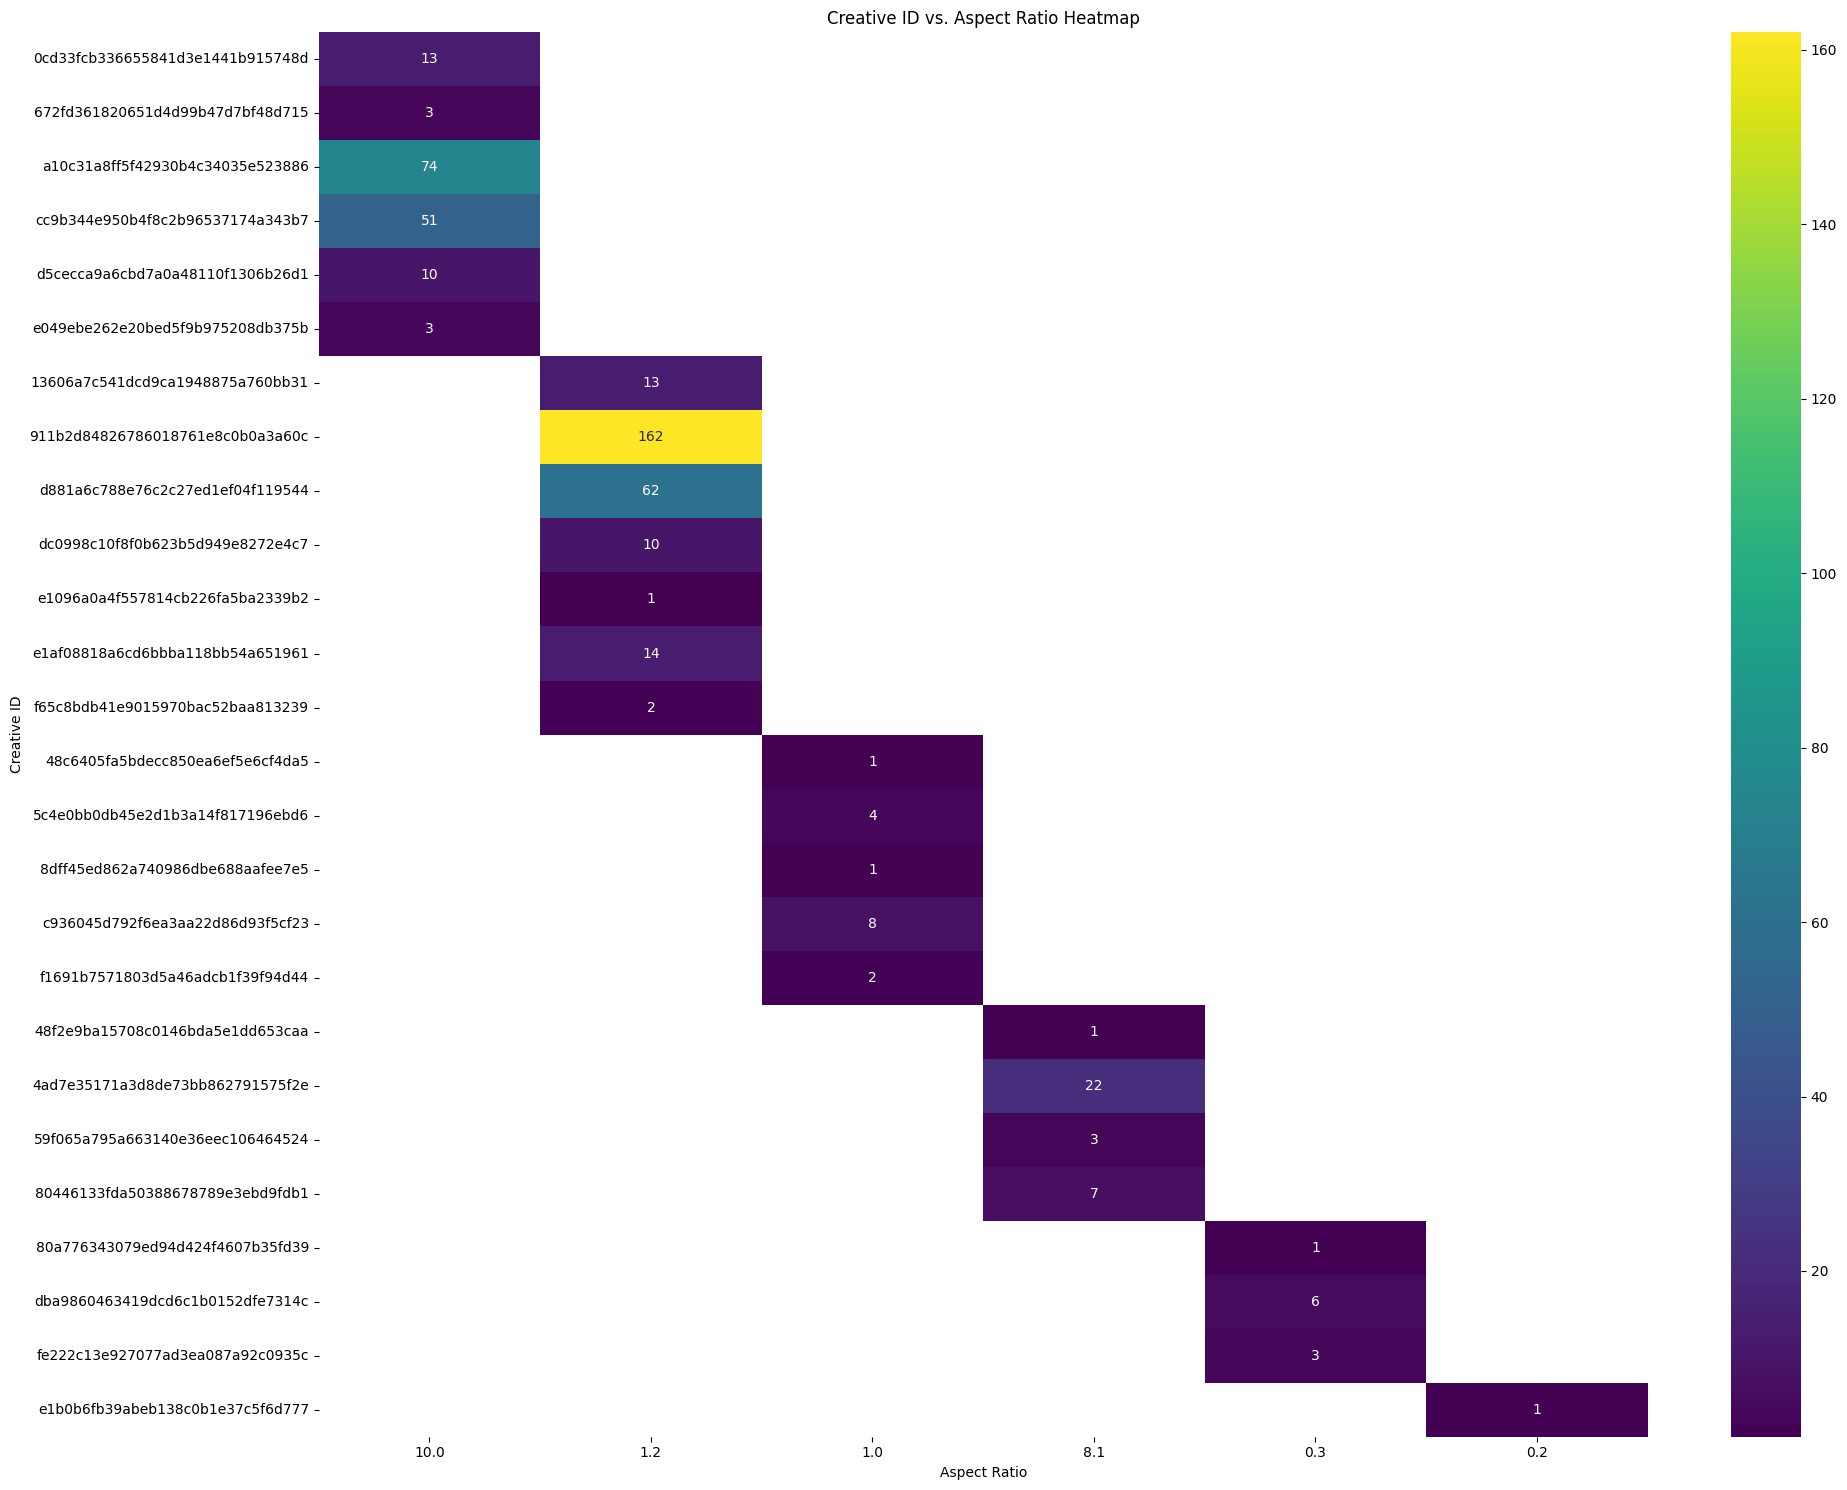

In [13]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_from_json(json_file_path, figsize=(10, 8)):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame.from_dict(data, orient='index')

    plt.figure(figsize=figsize)
    sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f")  # Annotations and integer format
    plt.xlabel("Aspect Ratio")  # X-axis label
    plt.ylabel("Creative ID")  # Y-axis label
    plt.title("Creative ID vs. Aspect Ratio Heatmap") # Title
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
    plt.show()

# Example usage:
plot_heatmap_from_json("creative_adtype_map.json", figsize=(20, 15)) # Adjust figsize as needed

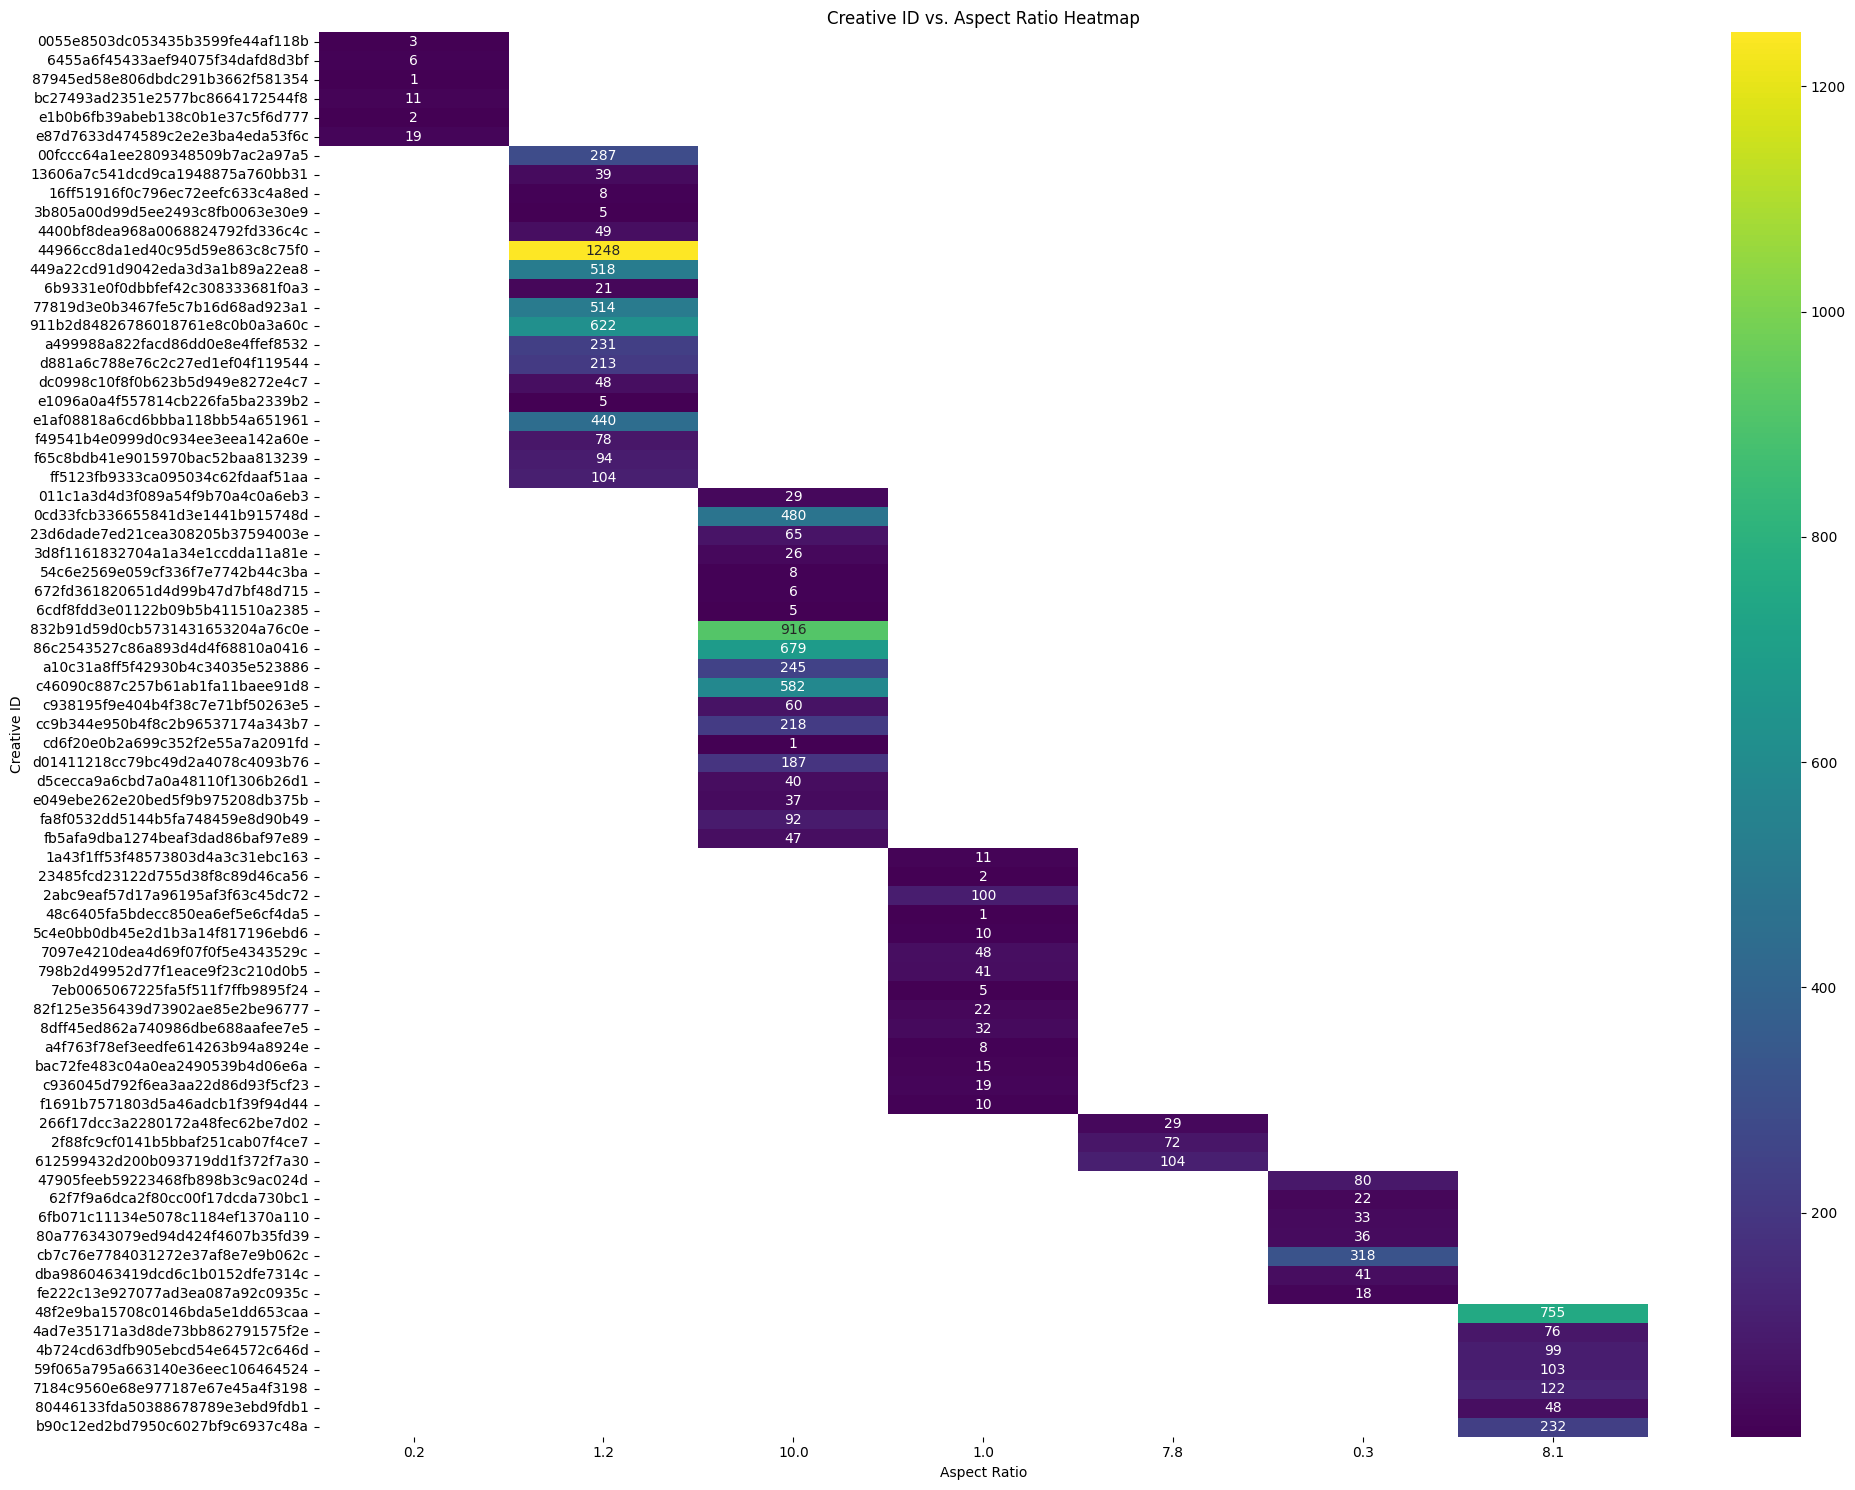

In [9]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap_from_json(json_file_path, figsize=(10, 8)):
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    df = pd.DataFrame.from_dict(data, orient='index')

    plt.figure(figsize=figsize)
    sns.heatmap(df, cmap="viridis", annot=True, fmt=".0f")  # Annotations and integer format
    plt.xlabel("Aspect Ratio")  # X-axis label
    plt.ylabel("Creative ID")  # Y-axis label
    plt.title("Creative ID vs. Aspect Ratio Heatmap") # Title
    plt.tight_layout() # Adjust layout to prevent labels from being cut off
    plt.show()

# Example usage:
plot_heatmap_from_json("creative_adtype_map.json", figsize=(20, 15)) # Adjust figsize as needed